In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn
import torch as th
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

In [ ]:
data0 = np.load("./input/multidigittrainingdata/DL-Project/data0.npy")
lab0 = np.load("./input/multidigittrainingdata/DL-Project/lab0.npy")
data1 = np.load("./input/multidigittrainingdata/DL-Project/data1.npy")
lab1 = np.load("./input/multidigittrainingdata/DL-Project/lab1.npy")
data2 = np.load("./input/multidigittrainingdata/DL-Project/data2.npy")
lab2 = np.load("./input/multidigittrainingdata/DL-Project/lab2.npy")

So our numbers can have leading 0s, so our range of values, that we can have is from 0 to 36, so our output one hot encoded tensor, will be 37 long.

25


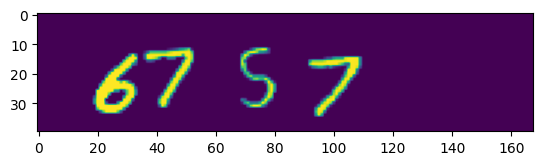

In [4]:
train_val_data = np.concatenate((data0,data1))
test_data = data2
train_val_labels = np.concatenate((lab0,lab1))
test_labels = lab2

t = np.random.randint(10000,20000)
print(train_val_labels[t])
plt.imshow(train_val_data[t])

In [5]:
def one_hot_encoding(num):
    ## maximum possible sum of a 4 digit number is 36
    y = th.zeros(37)
    y[num]=1
    return y

class DigitSumDataset(Dataset):
    def __init__(self,images,sums):
        self.images =images/255
        self.sums = sums
    def __len__(self):
        return(len(self.sums))
    def __getitem__(self,idx):
        img = self.images[idx] 
        # img = img - np.mean(img) ## mean scaling it.
        return(th.tensor(img).reshape(1,40,168).float(),one_hot_encoding(self.sums[idx]))

In [7]:
train_img, val_img, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels, 
    test_size=0.2,  # or train_size=0.8
)

In [8]:
TrS = DigitSumDataset(train_img,train_labels)
VaS  = DigitSumDataset(val_img,val_labels)
TeS = DigitSumDataset(test_data,test_labels)
TrainSet = DataLoader(TrS,batch_size=32)
ValSet = DataLoader(VaS,batch_size=32)
TestSet = DataLoader(TeS,batch_size=32)

In [ ]:
## Each Image is 1,40*168

## output must be a single value
from torch.nn import functional as F

    
class BaselineCNN(nn.Module):
    ### 40 *168 image that should be made into a 36 valued tensor
    def __init__(self,inp_channels):
        super(BaselineCNN,self).__init__()
        self.convblock =nn.Sequential(nn.Conv2d(in_channels = inp_channels,
                                                out_channels = 16, kernel_size = (3,3)),
                                       ## current shape: 38,166,16
                                       nn.MaxPool2d(2),
                                       ##current shape: 19,88,16
                                       nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(5,5)),
                                       ## current shape : 15,84,4
                                       nn.MaxPool2d(3),
                                      #current shape : 5,26,32
                                       nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1),
                                      nn.Conv2d(in_channels=16,out_channels=8,kernel_size=2),
                                      )
        ## now our image has 20*28 = 560 dimensions, we pass it through two fc layers
        self.fc_layer = nn.Sequential(
            nn.Linear(800,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,37),
        )
    def forward(self,x):
        convolved = self.convblock(x)
        output = self.fc_layer(convolved.view(-1,800))
        return output

test_inp = th.randn(size=(5,1,40,168))
testmod = BaselineCNN(1)
with th.no_grad():
    print(testmod(test_inp).shape)
    print(testmod(test_inp).sum(dim=1))
    print(testmod(test_inp))
        
        
        
    
    

In [10]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [ ]:
model = BaselineCNN(1).to(device)
model.load_state_dict(th.load("./checkpoints/model_25.pth"))

In [25]:
def plot_batch(images, preds, true_sums, num_images=8):
    """
    Plots a grid of images with their predicted and true sum values.

    Args:
        images (Tensor): Batch of images.
        preds (Tensor): Predicted sum values.
        true_sums (Tensor): True sum values.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i]
        if img.shape[0] == 1:  # Grayscale
            img = img.squeeze(0)
            plt.imshow(img, cmap='gray')
        else:
            img = img.permute(1, 2, 0)  # CHW to HWC
            plt.imshow(img)
        plt.title(f"Pred: {preds[i]}, True: {true_sums[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Testing: 100%|██████████| 313/313 [00:01<00:00, 223.20batch/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



Average Test Accuracy: 8.83%
Average Test Loss: 13.0995

Overall Error Statistics:
Mean Error: -0.32
Median Error: 0.00
Min Error: -17
Max Error: 19
Std Deviation of Error: 4.47


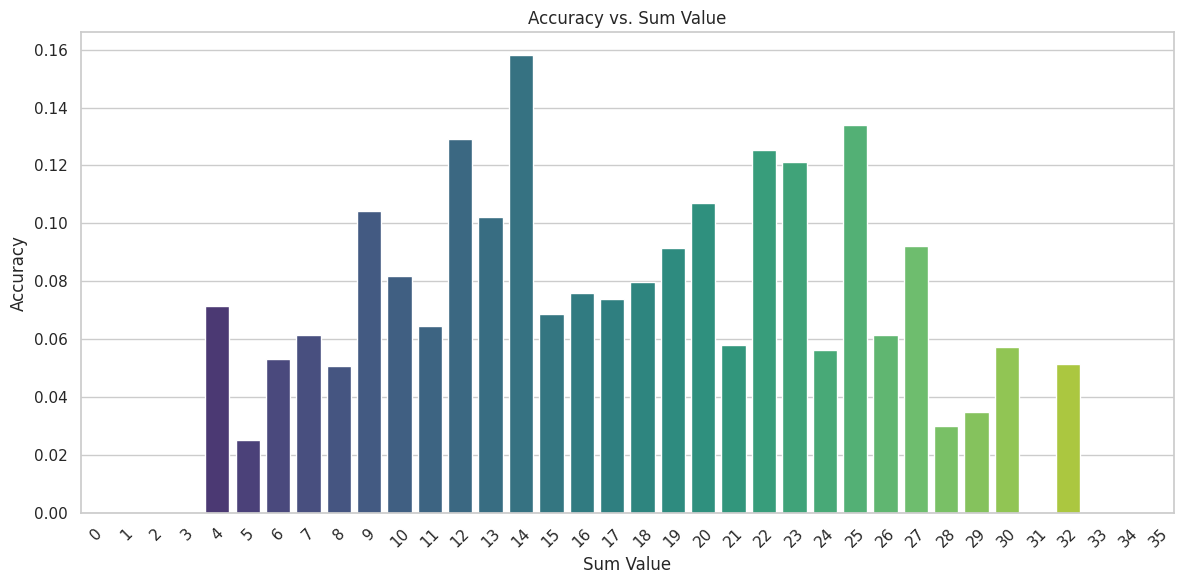

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


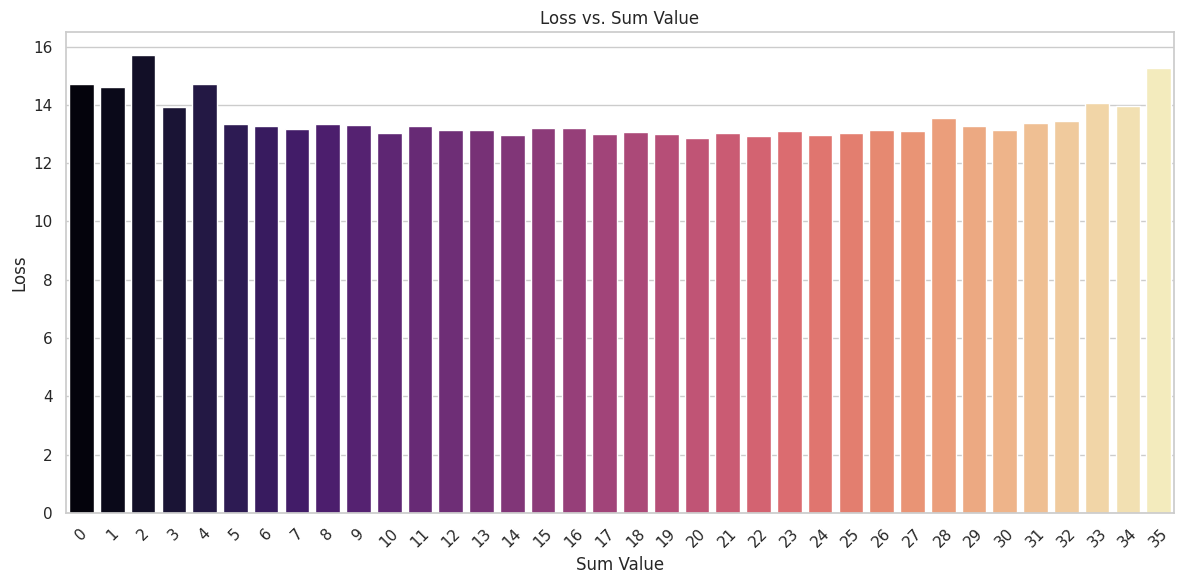

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


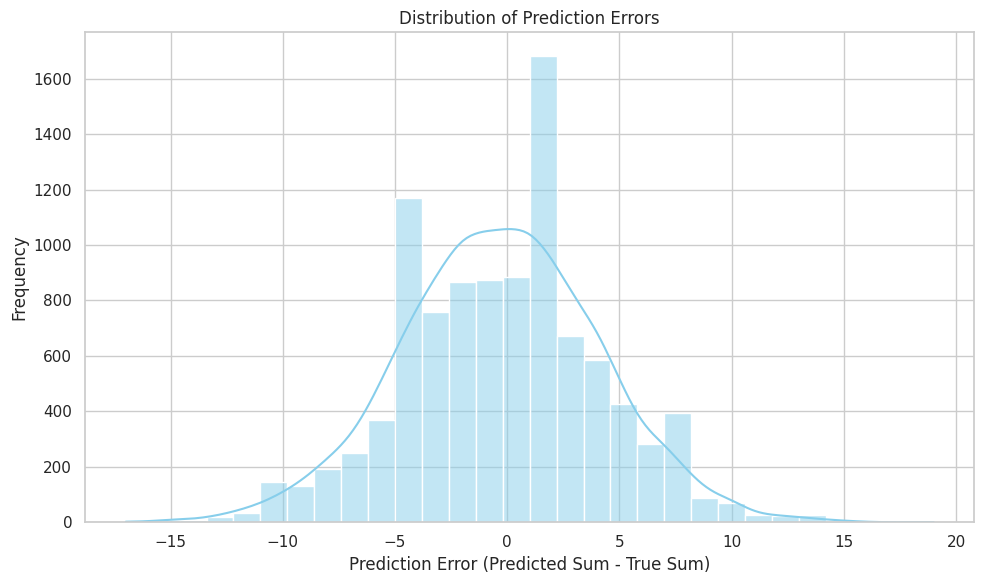

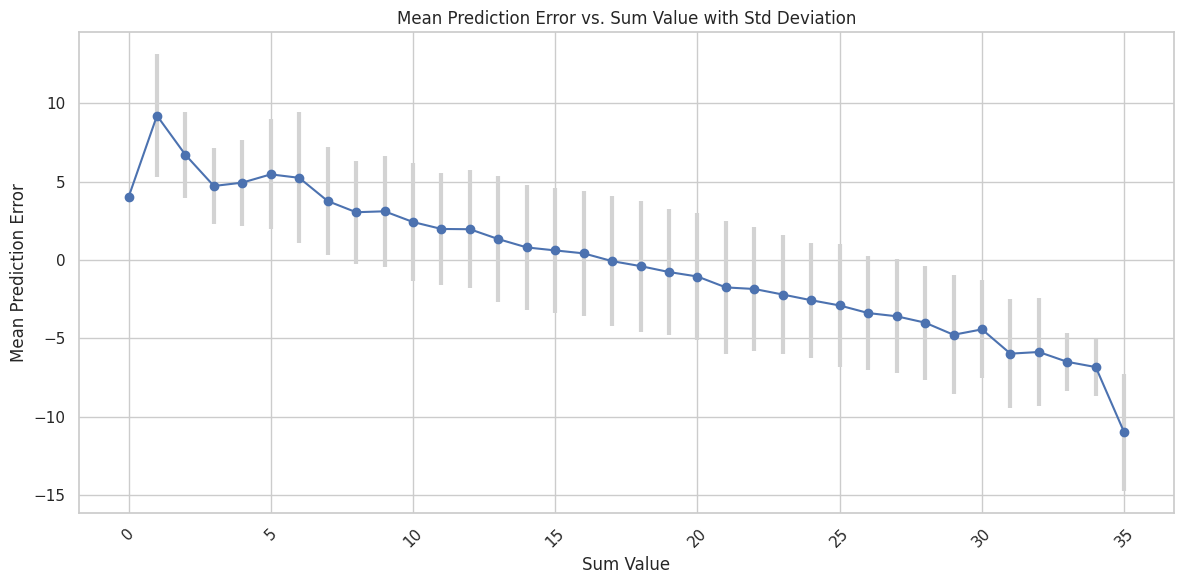

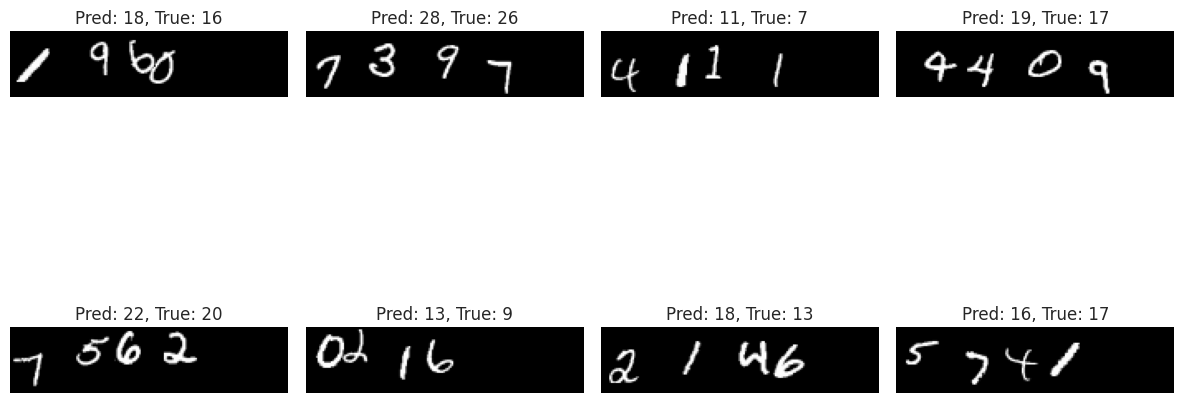


Predicted Sums for Last Batch: [18, 28, 11, 19, 22, 13, 18, 16, 14, 13, 22, 14, 16, 19, 17, 29]


In [ ]:
import torch as th
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure seaborn styles are set
sns.set(style="whitegrid")


# Initialize lists and dictionaries to store metrics
epoch_test_accuracies = []
epoch_test_losses = []

# Dictionaries to accumulate loss and accuracy per sum value
loss_per_sum = {}
accuracy_per_sum = {}
count_per_sum = {}

# Dictionaries for error analysis
error_per_sum = {}
errors_all = []

# To store the last batch data for plotting
last_batch_images = None
last_batch_preds = None
last_batch_true_sums = None

model.eval()  # Set model to evaluation mode

criterion = nn.CrossEntropyLoss()
with th.no_grad():
    # Wrap TestSet with tqdm for the progress bar
    for images, sums in tqdm(TestSet, desc="Testing", unit="batch"):
        images = images.to(device)
        sums = sums.to(device)

        output = model(images)
        loss = criterion(output, sums)

        preds = th.argmax(output.cpu(), dim=1)
        true_sums = th.argmax(sums.cpu(), dim=1)

        # Calculate accuracy for the batch
        accuracy = (preds == true_sums).float().mean().item()

        epoch_test_accuracies.append(accuracy)
        epoch_test_losses.append(loss.item())

        # Calculate error (pred - true)
        errors = preds - true_sums
        errors_all.extend(errors.cpu().numpy())

        # Update loss, accuracy, and error per sum value
        for pred, true_sum, error in zip(preds, true_sums, errors):
            sum_val = true_sum.item()
            error_val = error.item()

            # Update loss
            loss_per_sum[sum_val] = loss_per_sum.get(sum_val, 0.0) + loss.item()

            # Update accuracy
            accuracy_per_sum[sum_val] = accuracy_per_sum.get(sum_val, 0.0) + (pred == true_sum).float().item()

            # Update count
            count_per_sum[sum_val] = count_per_sum.get(sum_val, 0) + 1

            # Update error
            if sum_val in error_per_sum:
                error_per_sum[sum_val].append(error_val)
            else:
                error_per_sum[sum_val] = [error_val]

        # Store last batch data
        last_batch_images = images.cpu()
        last_batch_preds = preds
        last_batch_true_sums = true_sums

    # Calculate average validation metrics
    avg_test_accuracy = sum(epoch_test_accuracies) / len(epoch_test_accuracies)
    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)

    print(f"\nAverage Test Accuracy: {avg_test_accuracy*100:.2f}%")
    print(f"Average Test Loss: {avg_test_loss:.4f}")

    # Calculate average loss and accuracy per sum value
    avg_loss_per_sum = {k: v / count_per_sum[k] for k, v in loss_per_sum.items()}
    avg_accuracy_per_sum = {k: v / count_per_sum[k] for k, v in accuracy_per_sum.items()}

    # Calculate error statistics per sum value
    error_stats_per_sum = {}
    for sum_val, errors in error_per_sum.items():
        errors_np = np.array(errors)
        mean_error = np.mean(errors_np)
        median_error = np.median(errors_np)
        min_error = np.min(errors_np)
        max_error = np.max(errors_np)
        error_stats_per_sum[sum_val] = {
            'mean_error': mean_error,
            'median_error': median_error,
            'min_error': min_error,
            'max_error': max_error,
            'std_error': np.std(errors_np)
        }

    # Overall error statistics
    errors_all_np = np.array(errors_all)
    overall_mean_error = np.mean(errors_all_np)
    overall_median_error = np.median(errors_all_np)
    overall_min_error = np.min(errors_all_np)
    overall_max_error = np.max(errors_all_np)
    overall_std_error = np.std(errors_all_np)

    print("\nOverall Error Statistics:")
    print(f"Mean Error: {overall_mean_error:.2f}")
    print(f"Median Error: {overall_median_error:.2f}")
    print(f"Min Error: {overall_min_error}")
    print(f"Max Error: {overall_max_error}")
    print(f"Std Deviation of Error: {overall_std_error:.2f}")

    # Calculate average loss and accuracy per sum value
    avg_loss_per_sum_sorted = {k: avg_loss_per_sum[k] for k in sorted(avg_loss_per_sum.keys())}
    avg_accuracy_per_sum_sorted = {k: avg_accuracy_per_sum[k] for k in sorted(avg_accuracy_per_sum.keys())}

    # Plotting Accuracy vs Sum Value
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(avg_accuracy_per_sum_sorted.keys()), y=list(avg_accuracy_per_sum_sorted.values()), palette="viridis")
    plt.xlabel('Sum Value')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Sum Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting Loss vs Sum Value
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(avg_loss_per_sum_sorted.keys()), y=list(avg_loss_per_sum_sorted.values()), palette="magma")
    plt.xlabel('Sum Value')
    plt.ylabel('Loss')
    plt.title('Loss vs. Sum Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting Error Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(errors_all_np, bins=30, kde=True, color='skyblue')
    plt.xlabel('Prediction Error (Predicted Sum - True Sum)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.tight_layout()
    plt.show()

    # Plotting Mean Error vs Sum Value
    mean_errors = [error_stats_per_sum[k]['mean_error'] for k in sorted(error_stats_per_sum.keys())]
    std_errors = [error_stats_per_sum[k]['std_error'] for k in sorted(error_stats_per_sum.keys())]
    sum_values = sorted(error_stats_per_sum.keys())

    plt.figure(figsize=(12, 6))
    plt.errorbar(sum_values, mean_errors, yerr=std_errors, fmt='o-', ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel('Sum Value')
    plt.ylabel('Mean Prediction Error')
    plt.title('Mean Prediction Error vs. Sum Value with Std Deviation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting the last batch using plot_batch function
    if last_batch_images is not None:
        plot_batch(last_batch_images, last_batch_preds, last_batch_true_sums)
        print("\nPredicted Sums for Last Batch:", last_batch_preds.tolist())


In [19]:
print(avg_test_accuracy,avg_test_loss)

0.09175319488817892 12.615561625447135
